<a href="https://colab.research.google.com/github/handoyo1712/Trending-Youtube-EDA-/blob/master/Compare_Trending_Video_youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook will walk you through some data exploration and deeper analysis on Youtube Trending Video Statistic in between countries like US, Canada, United Kingdom, France and Germany. We will go through 2 session in this notebook:

* How long usually a video can trend in different countries?
* How many likes, dislikes, views and comments get by different countries?
* Correlation of trending video in between countries
* Videos from which category has longer trend?
* Correlation between Days of Publish to Trend v/s Trending Duration
* Users like videos from which CATEGORY the most?
* What is the ratio of Likes-Dislikes and Views-Comments in different categories?
* What's the tags in the most negative and most positive category? What's the * * most discuss words for Science & Technology?

In [2]:
# Import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
# Input data files are available in the directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os

In [3]:
files = [i for i in glob.glob('drive/MyDrive/Dataset/*.{}'.format('csv'))]
sorted(files)

['drive/MyDrive/Dataset/CAvideos.csv',
 'drive/MyDrive/Dataset/DEvideos.csv',
 'drive/MyDrive/Dataset/FRvideos.csv',
 'drive/MyDrive/Dataset/GBvideos.csv',
 'drive/MyDrive/Dataset/USvideos.csv']

## **Combine all the statistics from different regions**
Let's see what we got in this combined sheet.

In [10]:
dfs = list()
for file in files:
    df = pd.read_csv(file, index_col='video_id')
    df['country'] = file[22:24]  # to put string in every files name, which have become country's column for every data set in files
    dfs.append(df)

my_df = pd.concat(dfs)
my_df.head(3)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
video_id,,,,,,,,,,,,,,,,
n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,CA
0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,CA
5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,CA


## **Reformat the date time and removed the incompleted rows**

In [11]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202310 entries, n1WpP7iowLc to ooyjaVdt-jA
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   trending_date           202310 non-null  object
 1   title                   202310 non-null  object
 2   channel_title           202310 non-null  object
 3   category_id             202310 non-null  int64 
 4   publish_time            202310 non-null  object
 5   tags                    202310 non-null  object
 6   views                   202310 non-null  int64 
 7   likes                   202310 non-null  int64 
 8   dislikes                202310 non-null  int64 
 9   comment_count           202310 non-null  int64 
 10  thumbnail_link          202310 non-null  object
 11  comments_disabled       202310 non-null  bool  
 12  ratings_disabled        202310 non-null  bool  
 13  video_error_or_removed  202310 non-null  bool  
 14  description             19

In [12]:
my_df['trending_date'] = pd.to_datetime(my_df['trending_date'],errors='coerce', format='%y.%d.%m')
my_df['publish_time'] = pd.to_datetime(my_df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')


In [7]:
my_df = my_df[my_df['trending_date'].notnull()]
my_df = my_df[my_df['publish_time'].notnull()]

my_df = my_df.dropna(how='any',inplace=False, axis = 0)

my_df.insert(4, 'publish_date', my_df['publish_time'].dt.date)
my_df['publish_time'] = my_df['publish_time'].dt.time

my_df_full = my_df.reset_index().sort_values('trending_date').set_index('video_id')
my_df = my_df.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
my_df[['publish_date','publish_time']].head()

,publish_date,publish_time
video_id,,
CCPX4EYrskw,2017-11-06,09:00:02
tSjvx_c4meE,2017-11-05,09:30:00
hIwRdDcQBEU,2017-11-06,16:33:36
1eS_17CG9sk,2017-11-05,12:03:04
IVRVXYCrr14,2017-11-05,18:00:01


In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74959 entries, CCPX4EYrskw to ooyjaVdt-jA
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           74959 non-null  datetime64[ns]
 1   title                   74959 non-null  object        
 2   channel_title           74959 non-null  object        
 3   category_id             74959 non-null  int64         
 4   publish_date            74959 non-null  object        
 5   publish_time            74959 non-null  object        
 6   tags                    74959 non-null  object        
 7   views                   74959 non-null  int64         
 8   likes                   74959 non-null  int64         
 9   dislikes                74959 non-null  int64         
 10  comment_count           74959 non-null  int64         
 11  thumbnail_link          74959 non-null  object        
 12  comments_disabled       74959 non-n

**We keep two set of data here:**

**my_df** (which only keep the last entry if duplicated because it carries latest stat)\
**my_df_full** ( full set of combined data, keep for later use)

## **Insert category column**

In [ ]:
my_df['category_id'] = my_df['category_id'].astype(str)
my_df_full['category_id'] = my_df['category_id'].astype(str)

category_id = {}

with open('drive/MyDrive/Dataset/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

my_df.insert(4, 'category', my_df['category_id'].map(category_id))
my_df_full.insert(4, 'category', my_df_full['category_id'].map(category_id))
category_list = my_df['category'].unique()
category_list

array(['Entertainment', 'Howto & Style', 'People & Blogs', 'Comedy',
       'Sports', 'Music', 'News & Politics', 'Film & Animation', 'Gaming',
       'Science & Technology', 'Education', 'Autos & Vehicles',
       'Pets & Animals', 'Shows', 'Travel & Events',
       'Nonprofits & Activism', 'Trailers', 'Movies'], dtype=object)

## **Analysis : How long usually a video can trend in different countries?**
The statistic provided has a key features to reflect how long a video trending which is the number of appearances. The greater the number of apperances indicate the long-last the video trend is. From here we can see that United Kingdom's list has the most long trended Youtube videos (Top 5 in the list is from GB).

In [ ]:
fre_df = pd.DataFrame(my_df_full.groupby([my_df_full.index,'country']).count()['title'].sort_values(ascending=False)).reset_index()
print(fre_df.head())
print(fre_df.tail())

      video_id country  title
0  2z3EUY1aXdY      GB     38
1  BhIEIO0vaBE      GB     38
2  NooW_RbfdWI      GB     38
3  u_C4onVrr8U      GB     38
4  Il-an3K9pjg      GB     38
          video_id country  title
89376  _lm9AoOQ9vQ      DE      1
89377  _lhibYD39Gs      CA      1
89378  _lg8sNpeOUM      CA      1
89379  _ldNAKG0eJ4      CA      1
89380  --2K8l6BWfw      FR      1


## **Let's visualize the stats above using line graphs**

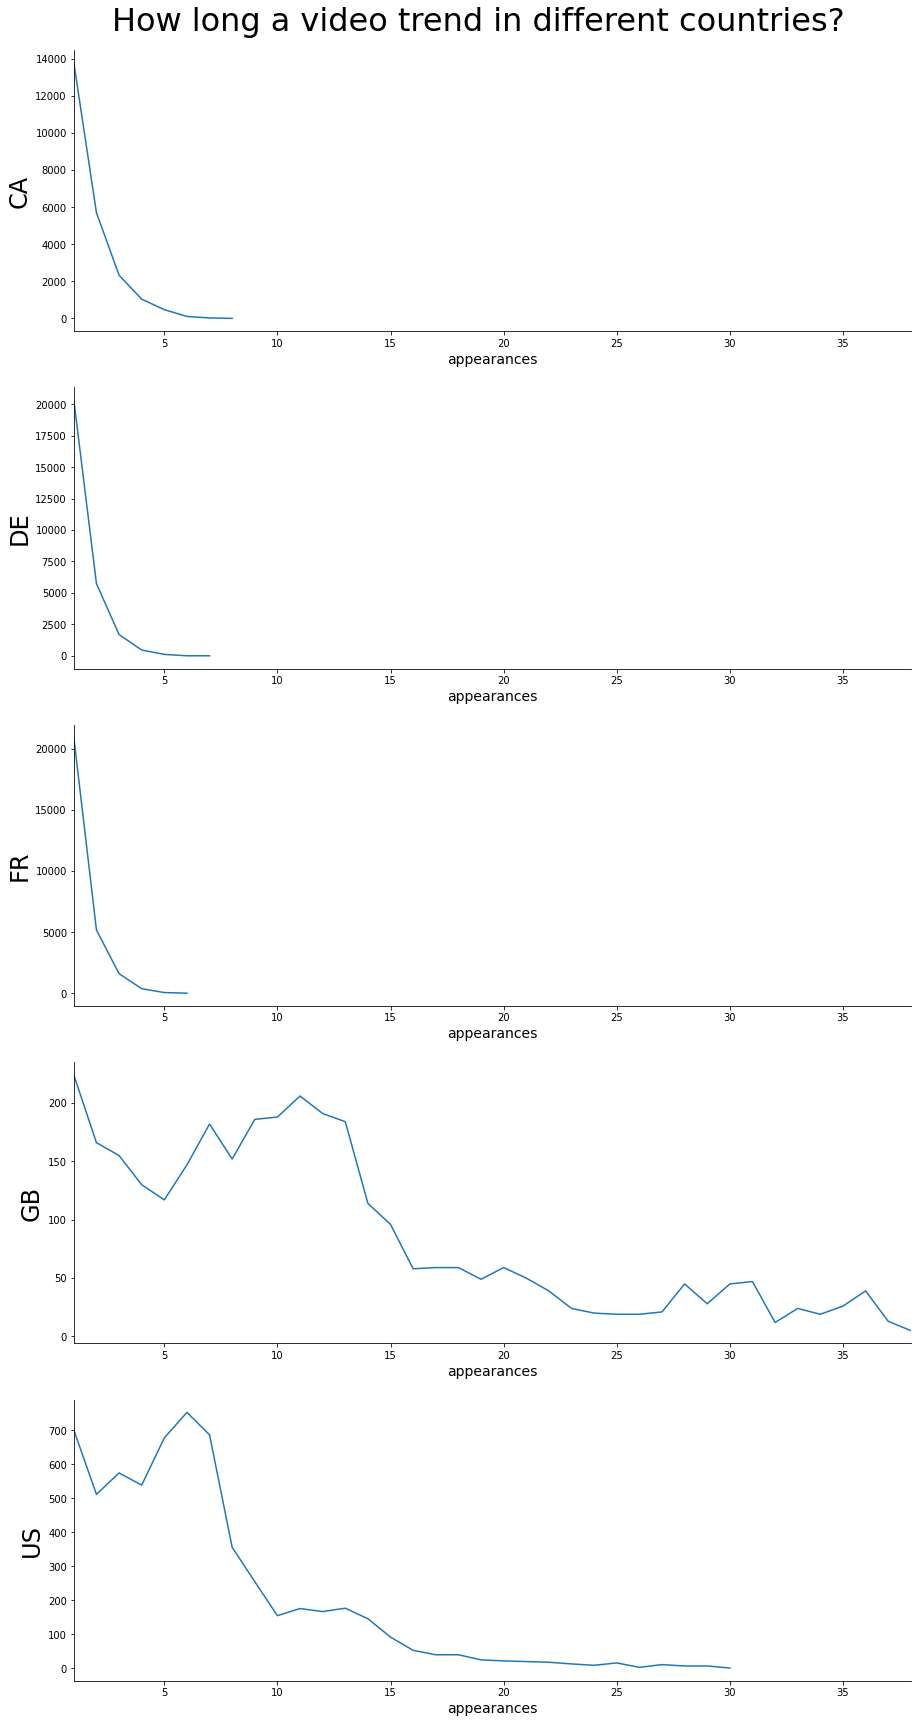

In [ ]:
video_list,max_list = list(),list()
country_list = my_df.groupby(['country']).count().index

for c in country_list:
    video_list.append(fre_df[fre_df['country']==c]['title'].value_counts().sort_index())
    max_list.append(max(fre_df[fre_df['country']==c]['title'].value_counts().sort_index().index))

fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(nrows=5,figsize=(15, 30))
st = fig.suptitle("How long a video trend in different countries?", fontsize=32)
st.set_y(0.9)
for i, pt in enumerate([ax0, ax1, ax2, ax3, ax4]):
    pt.plot(video_list[i].index, video_list[i])
    pt.spines['right'].set_visible(False)
    pt.spines['top'].set_visible(False)
    pt.set_xlabel("appearances",fontsize=14)
    pt.set_ylabel(country_list[i],fontsize=24)
    pt.axes.set_xlim(1, max(max_list))

From the line graphs above we can see that United Kingdom has numbers of enduring video in trend follow by US and Canada. In contrast, both France and Germany have very few video can last long in trending with max of 5 appearances in statistics.

## **Ratio of Youtube Trending Videos in 5 countries**
Since we have combined statistics from multiple countries, it's good to have a look on the number and ratio of videos we have in different countries. In this plot we keep only last entry for duplicated videos. That's why we can clearly observe that the country with the most long-trending video end up having lesser videos.

country
CA    18451
DE    23723
FR    24493
GB     3047
US     5245
Name: title, dtype: int64

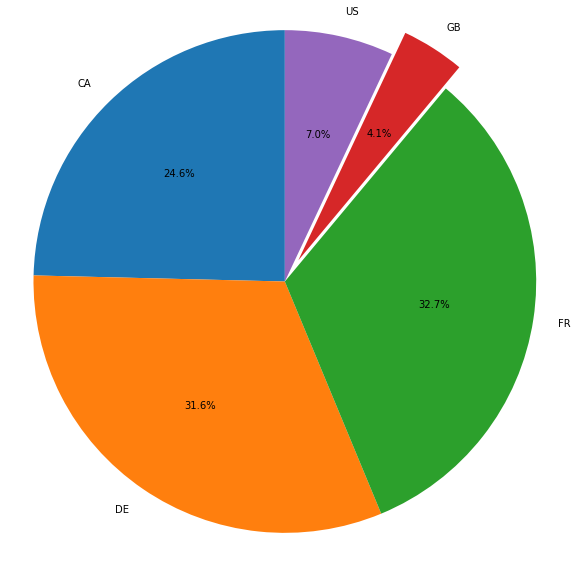

In [ ]:
labels = my_df.groupby(['country']).count().index
sizes = my_df.groupby(['country']).count()['title']
explode = (0, 0, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, explode=explode, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
sizes

## **Analysis : How many likes, dislikes, views and comments get by different countries?**

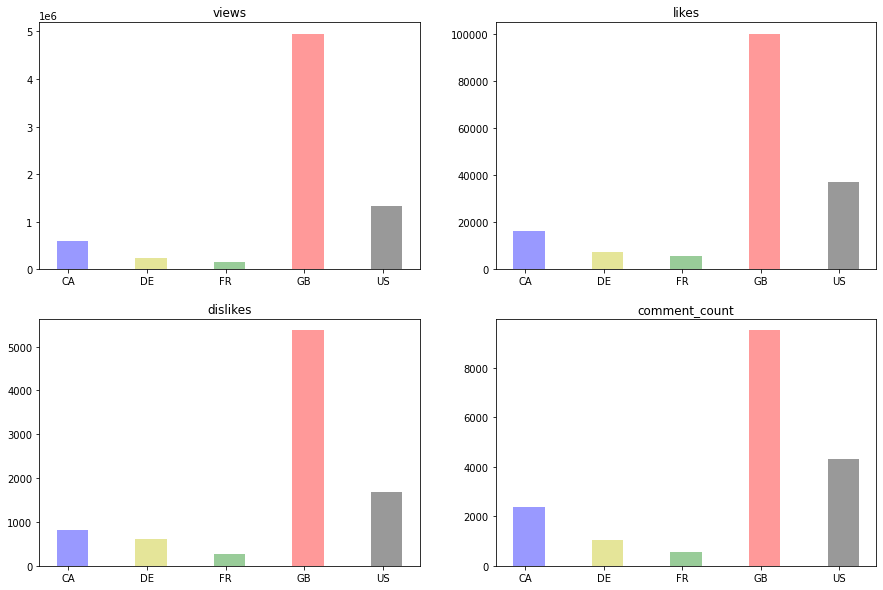

In [ ]:
to_int = ['views', 'likes', 'dislikes', 'comment_count']
for column in to_int:
    my_df[column] = my_df[column].astype(int)
    
measures = list()
n_groups = len(country_list)
for i, typ in enumerate(to_int):
    measure = list()
    for c in country_list:
        measure.append(my_df[my_df['country']==c][typ].agg('sum')/len(my_df[my_df['country']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,
                alpha=opacity, color=['b','y','g','r','k'],
                error_kw=error_config)
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(country_list)

Obviously, four of the graphs share the similar trend in numbers. One possible reason to this is due to the video's trending duration. Enduring trending videos have the advantages in getting more views, likes, dislikes and comments.

## **Analysis : Correlation of trending video in between countries**

**Question : Does the video trending in one country will trend in other countries too? If yes,how much do they correlate to each other?**

In [ ]:
corr_list = pd.DataFrame(fre_df['video_id'].unique(), columns=['video_id'])
for country_code in fre_df['country'].unique():
    corr_list[country_code] = 0
corr_list['total']=0
corr_list=corr_list.set_index('video_id')
#print new_list
for index , item in corr_list.iterrows():
    #print index
    total = 0
    for i ,row in fre_df[fre_df['video_id'] == index][['country','title']].iterrows():
        total += row['title']
        corr_list.loc[[index],[row['country']]] = row['title']
    corr_list.loc[[index],['total']] = total
corr_list.head()

,GB,US,CA,DE,FR,total
video_id,,,,,,
2z3EUY1aXdY,38,4,6,5,5,58
BhIEIO0vaBE,38,10,6,5,4,63
NooW_RbfdWI,38,10,6,5,3,62
u_C4onVrr8U,38,17,4,0,1,60
Il-an3K9pjg,38,0,0,0,0,38


Suprisingly the answer is YES. They do coexist in multiple list. Next, let's see how much do they correlate to each other.

## **Plot the Heatmaps of Correlation**

,GB,US,CA,DE,FR
GB,1.000000,0.209938,0.120504,-0.001573,-0.020790
US,0.209938,1.000000,0.186088,-0.021337,-0.078913
CA,0.120504,0.186088,1.000000,0.005099,-0.084698
DE,-0.001573,-0.021337,0.005099,1.000000,-0.213759
FR,-0.020790,-0.078913,-0.084698,-0.213759,1.000000


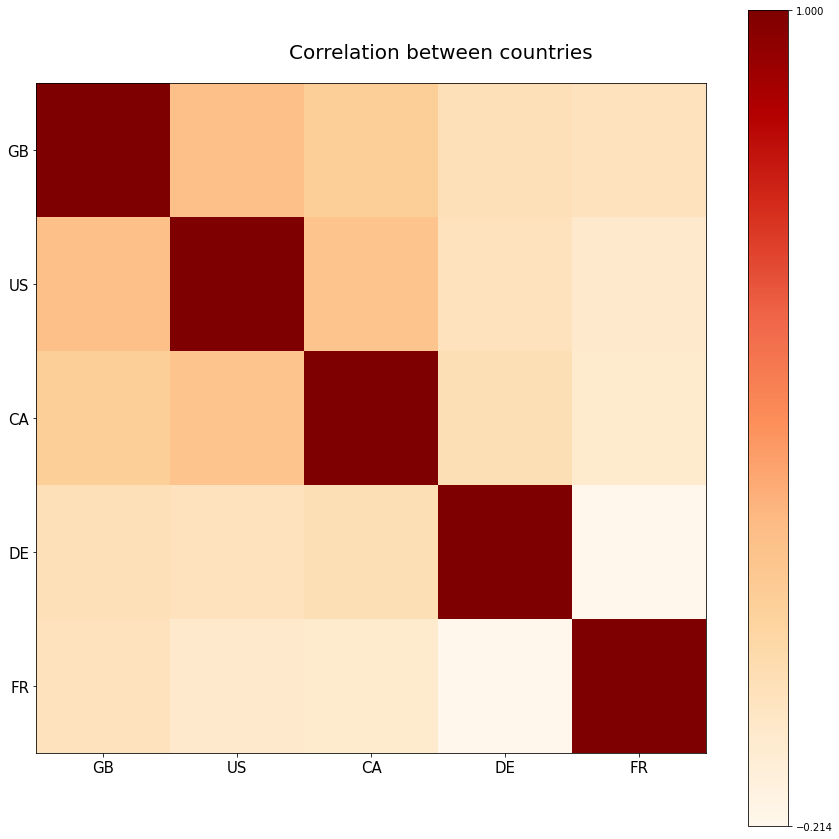

In [ ]:
countries = ['GB', 'US', 'CA', 'DE', 'FR'] #looking at correlations between these countries
corr_matrix = corr_list[countries].corr()

fig, ax = plt.subplots(figsize=(15,15))
fig.suptitle('Correlation between countries', fontsize=20).set_y(0.85)
heatmap = ax.imshow(corr_matrix, interpolation='nearest', cmap=cm.OrRd)

# making the colorbar on the side
cbar_min = corr_matrix.min().min()
cbar_max = corr_matrix.max().max()
cbar = fig.colorbar(heatmap, ticks=[cbar_min, cbar_max])

# making the labels
labels = ['']
for column in countries:
    labels.append(column)
#print labels
ax.set_yticklabels(labels, minor=False, fontsize=15)
ax.set_xticklabels(labels, minor=False, fontsize=15)
corr_matrix

Here we got the heatmap of correlation of Youtube Trending Videos between countries. Not suprisingly, the video from United Kingdom, US and Canada is highly correlate to each other compare to Germany and France. This might due to the sharing of common language in these contries. As compare, Germany and France seems like more isolate where they did not follow the trend from english speaking countries (Just my personal opinion by observing the heatmap). This can also explain why United Kingdom has the highest number in long-trend videos, as it is contributes by multiple contries at the same time.

## **Analysis : Users like videos from which CATEGORY the most?**

### **From United Kingdom Users :**

Text(0.5, 1.0, 'Catogories of trend videos in United Kingdom')

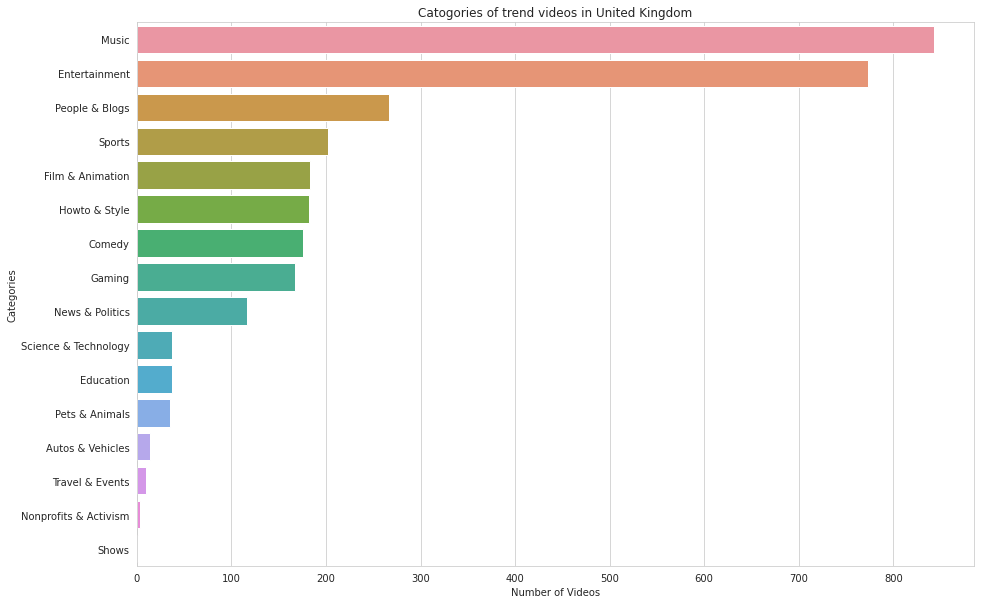

In [ ]:
cat_df_gb = my_df[my_df['country']=='GB']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_gb['index'],x=cat_df_gb['category'], data=cat_df_gb,orient='h')
plt.xlabel("Number of Videos")## From United Kingdom users : 
plt.ylabel("Categories")
plt.title("Catogories of trend videos in United Kingdom")

### **From US Users :**

Text(0.5, 1.0, 'Catogories of trend videos in US')

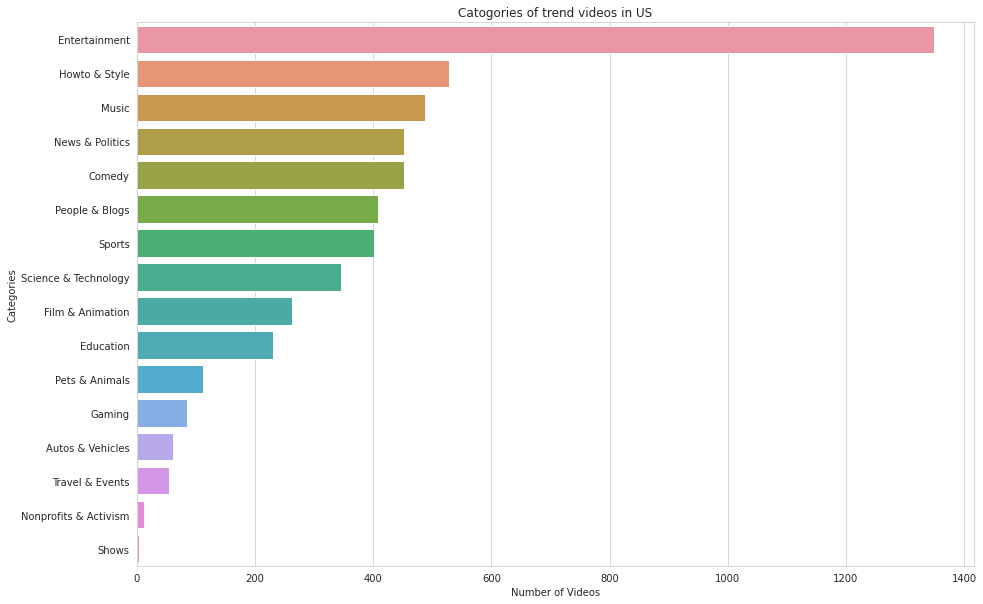

In [ ]:
cat_df_us = my_df[my_df['country']=='US']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_us['index'],x=cat_df_us['category'], data=cat_df_us,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in US")

### **From Canada Users:**

Text(0.5, 1.0, 'Catogories of trend videos in CANADA')

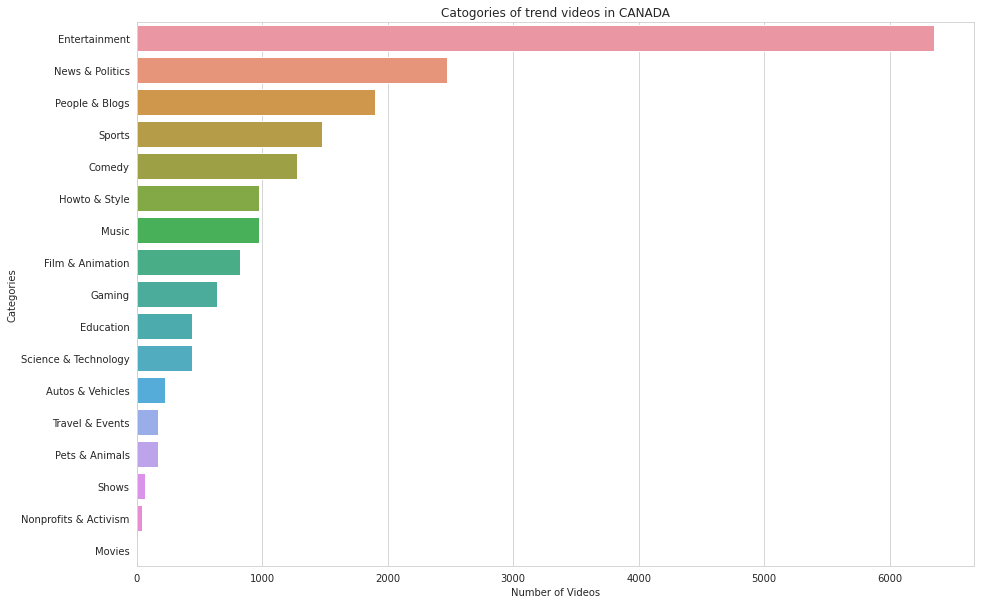

In [ ]:
cat_df_ca = my_df[my_df['country']=='CA']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_ca['index'],x=cat_df_ca['category'], data=cat_df_ca,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in CANADA")

### **From Germany Users:**

Text(0.5, 1.0, 'Catogories of trend videos in GERMANY')

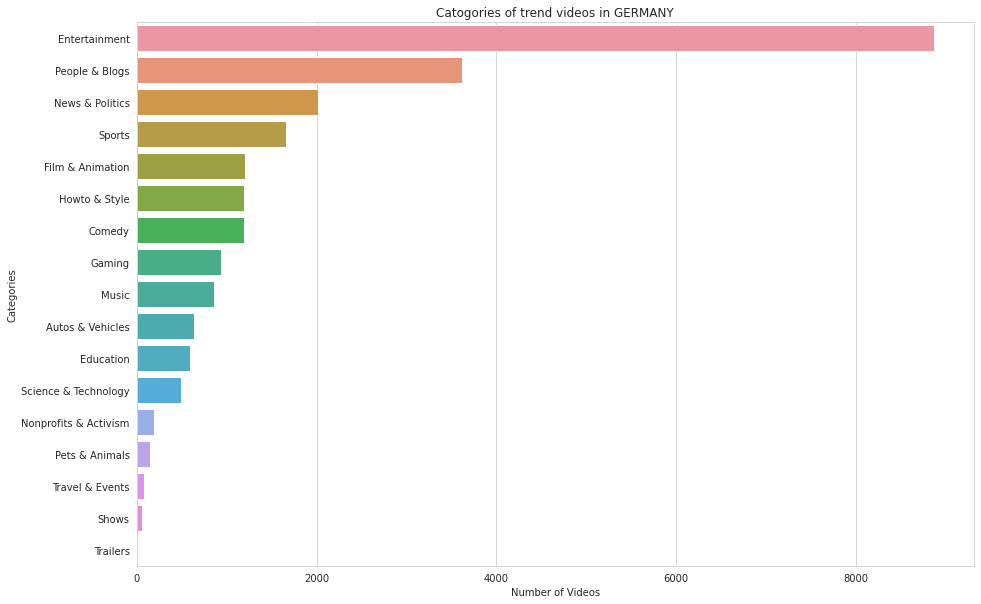

In [ ]:
cat_df_de = my_df[my_df['country']=='DE']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_de['index'],x=cat_df_de['category'], data=cat_df_de,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in GERMANY")

### **From France Users:**

Text(0.5, 1.0, 'Catogories of trend videos in FRANCE')

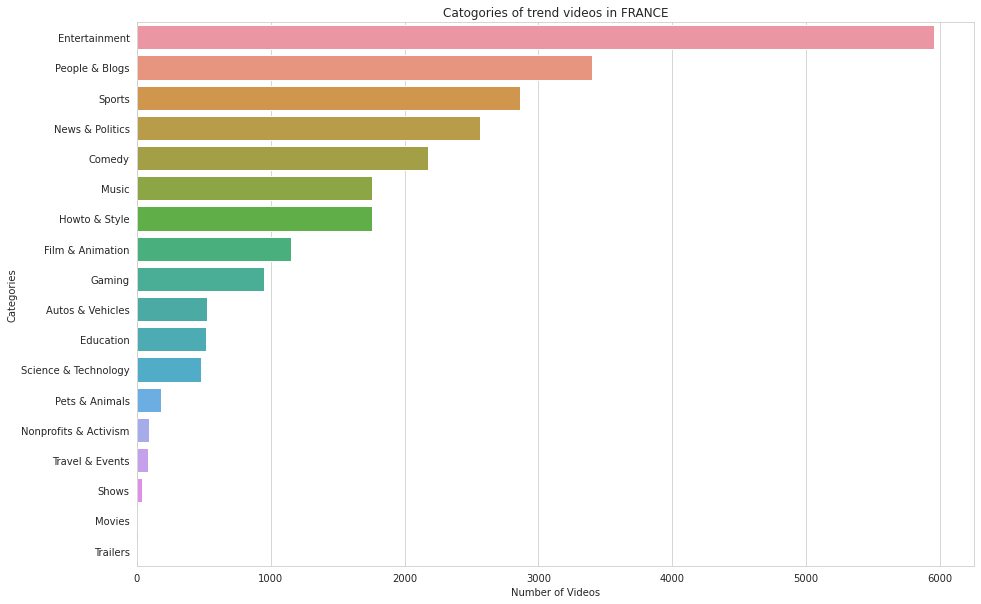

In [ ]:
cat_df_fr = my_df[my_df['country']=='FR']['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_fr['index'],x=cat_df_fr['category'], data=cat_df_fr,orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in FRANCE")

**Observation:**
1. Top category of all 5 countries is Entertainment.
2. Music's videos ranked insignificantly in Canada, Germany and France compare to US and UK.
3. Sport's videos are more popular in Canada, Germany and France.
4. All top 8 categories in United Kingdom entertainment-related, this might not be a good sign.
5. . Show's and Activism's video get the bottom rank in all most countries.\

Remarks: Please feel free to comment in below if you observe any interesting facts.

## **Analysis : Videos from which category has longer trend?**

### **Getting the days on trend for videos**

In [ ]:
publish_to_trend = {}
my_df_first = my_df_full.reset_index().drop_duplicates('video_id',keep ='first').set_index('video_id')
diff_first = (my_df_first['trending_date']).astype('datetime64[ns]')-my_df_first['publish_date'].astype('datetime64[ns]')

diff_first = diff_first.reset_index()
diff_first.columns = ['video_id','publish_to_trend']

for i, row in diff_first.iterrows():
    publish_to_trend[row['video_id']] = row['publish_to_trend'].days

my_df_last = my_df
diff_last = my_df['trending_date'].astype('datetime64[ns]')-my_df['publish_date'].astype('datetime64[ns]')
diff_last = diff_last.reset_index()
diff_last.columns = ['video_id','publish_to_trend_last']
my_df = my_df.reset_index()
my_df.insert(4,'publish_to_trend_last', diff_last['publish_to_trend_last'].astype('timedelta64[D]').astype(int))
my_df.insert(4, 'publish_to_trend', my_df['video_id'].map(publish_to_trend))
my_df.insert(4, 'trend_duration', 0)
my_df['trend_duration'] = (my_df['publish_to_trend_last']-my_df['publish_to_trend'])+1
my_df.set_index('video_id')[['publish_to_trend','trend_duration']].sort_values('trend_duration',ascending=False).head()

,publish_to_trend,trend_duration
video_id,,
BhIEIO0vaBE,1,38
2z3EUY1aXdY,0,38
NooW_RbfdWI,1,38
dzxFdtWmjto,1,37
1ce456Nnkt8,1,37


### **Heatmap : Categories v/s Trending Duration**

Text(0.5, 1.0, 'Category v/s Trending Duration')

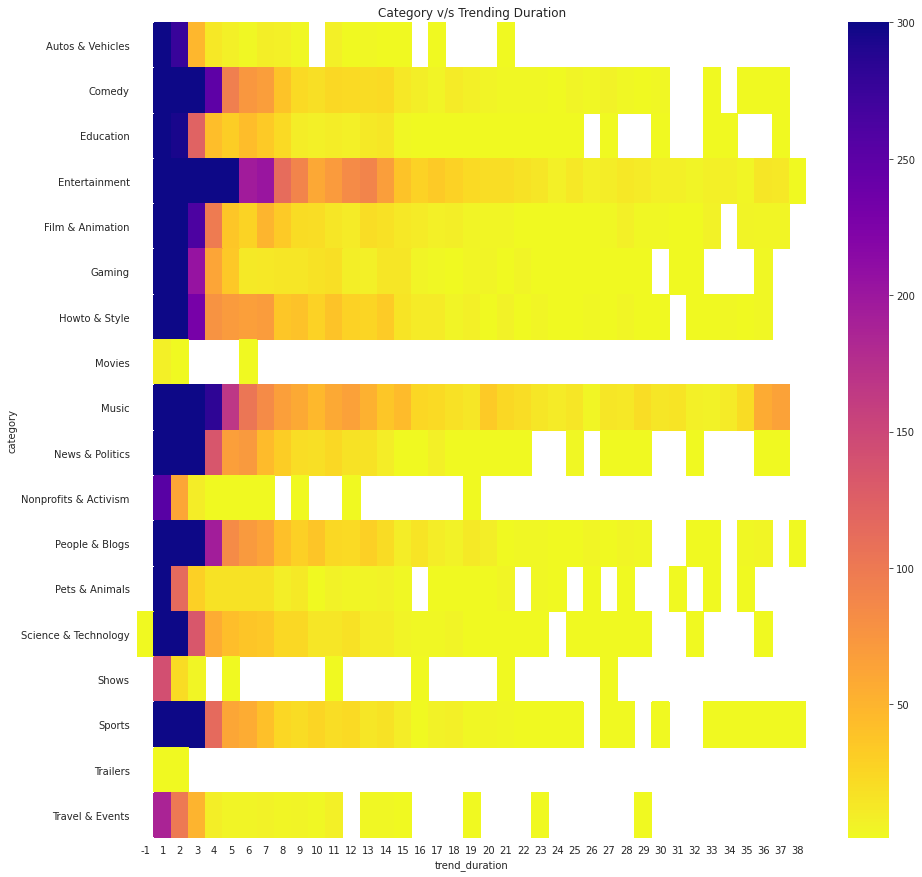

In [ ]:
cat_trend_duration= my_df.groupby(['category','trend_duration']).count()['video_id'].unstack().clip(upper=300)
plt.figure(figsize=(15,15))#You can Arrange The Size As Per Requirement
sns.heatmap(cat_trend_duration, cmap='plasma_r')
plt.title("Category v/s Trending Duration")

We clip number larger than 300 to have better intrepretation with smaller scale from (0 to 6000) -> (0 to 300). From the heatmap, we get the ranking of long trend categories:

1. Music
2. Entertainment
3. People & Blogs
4. Comedy
4. Sports, New & Politics and Howto & Style

## **Analysis : Correlation between Days of Publish to Trend v/s Trending Duration?**

###**Heatmap : Days of Publish to Trend v/s Trending Duration**

Text(0.5, 1.0, 'Correlation between Days from Publish v/s Trend and Trending Duration')

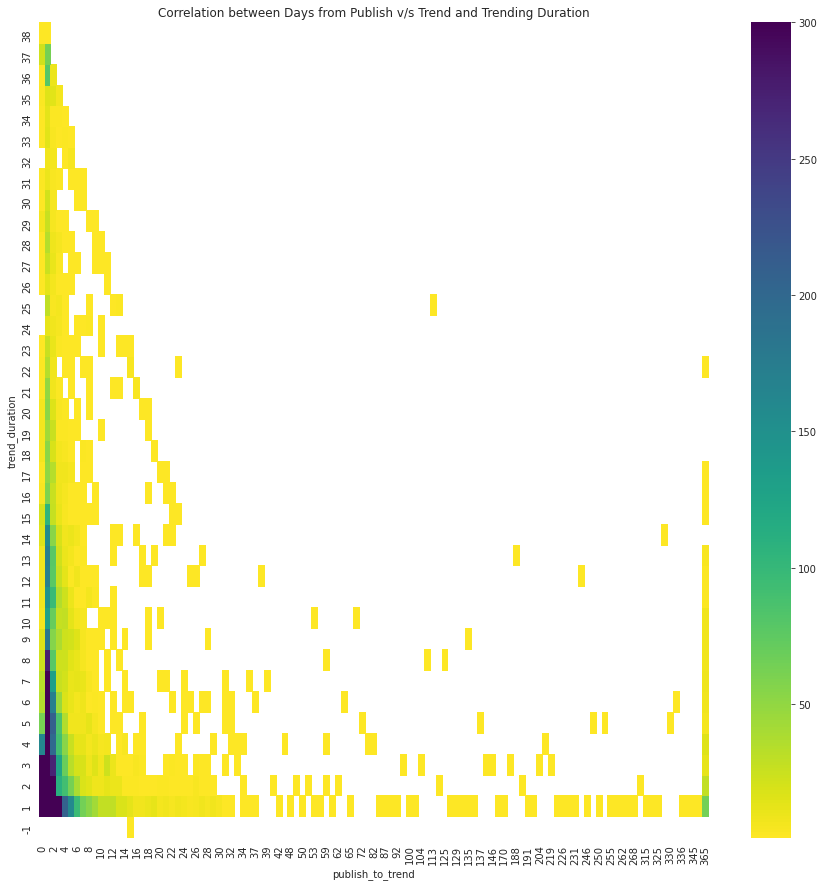

In [ ]:
my_df['publish_to_trend'] = my_df['publish_to_trend'].clip(upper=365)
cat_trend_duration= my_df.groupby(['trend_duration','publish_to_trend']).count()['video_id'].unstack().clip(upper=300)
plt.figure(figsize=(15,15))
ax = sns.heatmap(cat_trend_duration, cmap='viridis_r')
ax.invert_yaxis()
plt.title("Correlation between Days from Publish v/s Trend and Trending Duration")

We clip the days from publish to trend for any number larger than 365 (0 to 4825) -> (0 to 365). Suprisingly, there are some videos take few years to be on trend. These are some obeservation:

1. The less days needed for a video from publish to trend, the longer the trend duration.
2. Videos that can get into trending within 5 days will have higher probability to be trending for longer time.

## **Analysis : What is the ratio of Likes-Dislikes and Views-Comments in different categories?¶**

### **Likes-Dislikes Ratio**

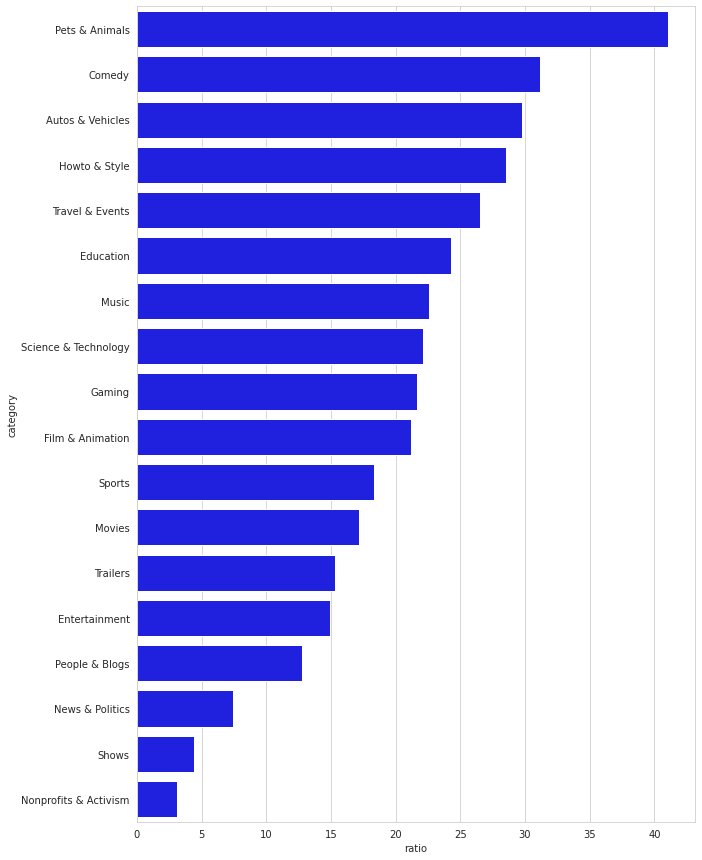

In [ ]:
like_dislike_ratio = my_df.groupby('category')['likes'].agg('sum') / my_df.groupby('category')['dislikes'].agg('sum')
like_dislike_ratio = like_dislike_ratio.sort_values(ascending=False).reset_index()
like_dislike_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=like_dislike_ratio,
            label="Likes-Dislikes Ratio", color="b")

###**Views-Comments Ratio**

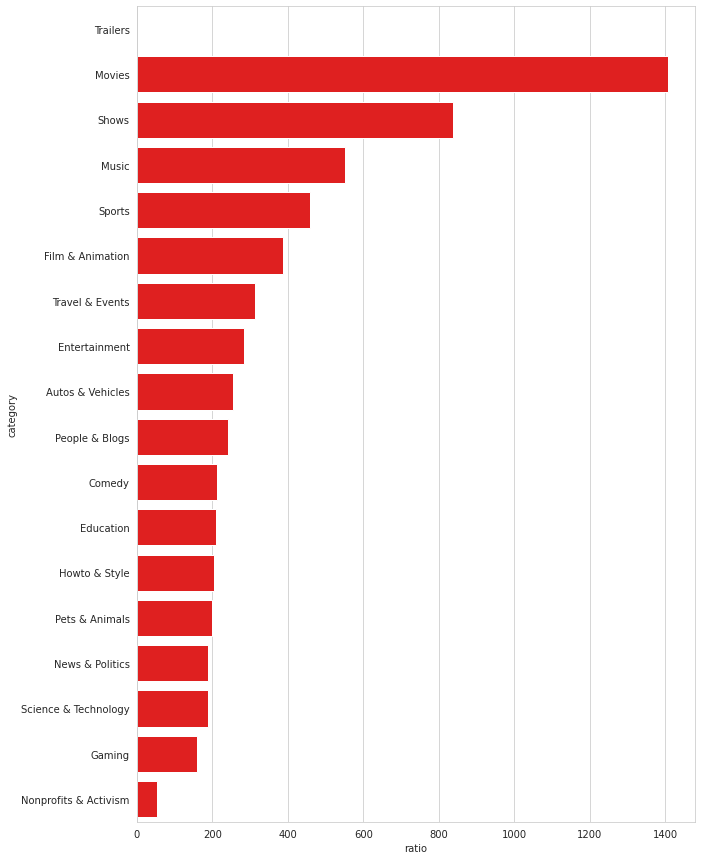

In [ ]:
views_comment_ratio = my_df.groupby('category')['views'].agg('sum') / my_df.groupby('category')['comment_count'].agg('sum')
views_comment_ratio = views_comment_ratio.sort_values(ascending=False).reset_index()
views_comment_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=views_comment_ratio,
            label="Views-Comments Ratio", color="r")

###**Dislikes-Views Ratio**

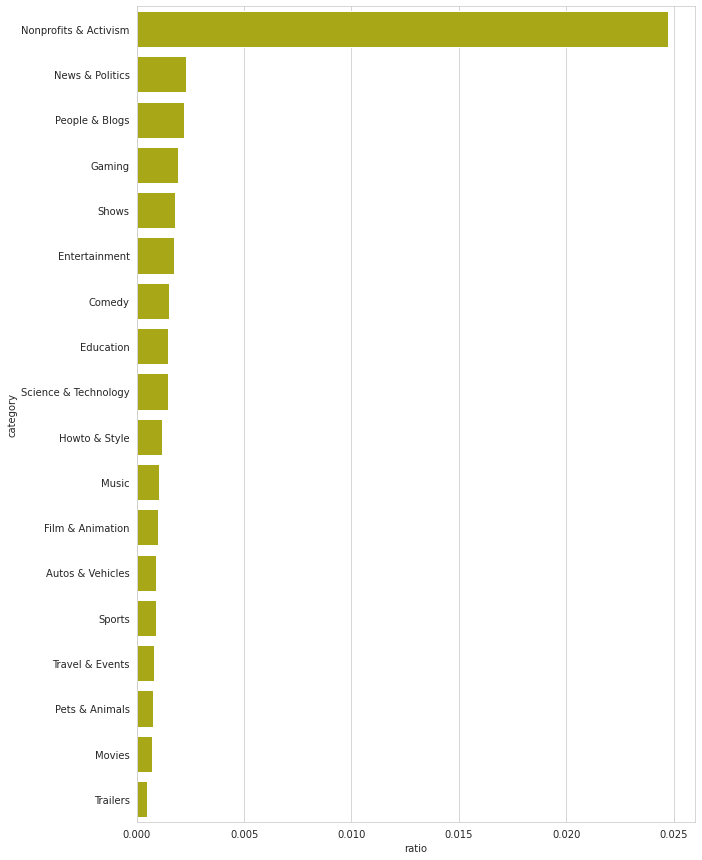

In [ ]:
view_dislike_ratio = my_df.groupby('category')['dislikes'].agg('sum') / my_df.groupby('category')['views'].agg('sum')
view_dislike_ratio = view_dislike_ratio.sort_values(ascending=False).reset_index()
view_dislike_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=view_dislike_ratio,
            label="Views-Dislikes Ratio", color="y")

###**Likes-Views Ratio**

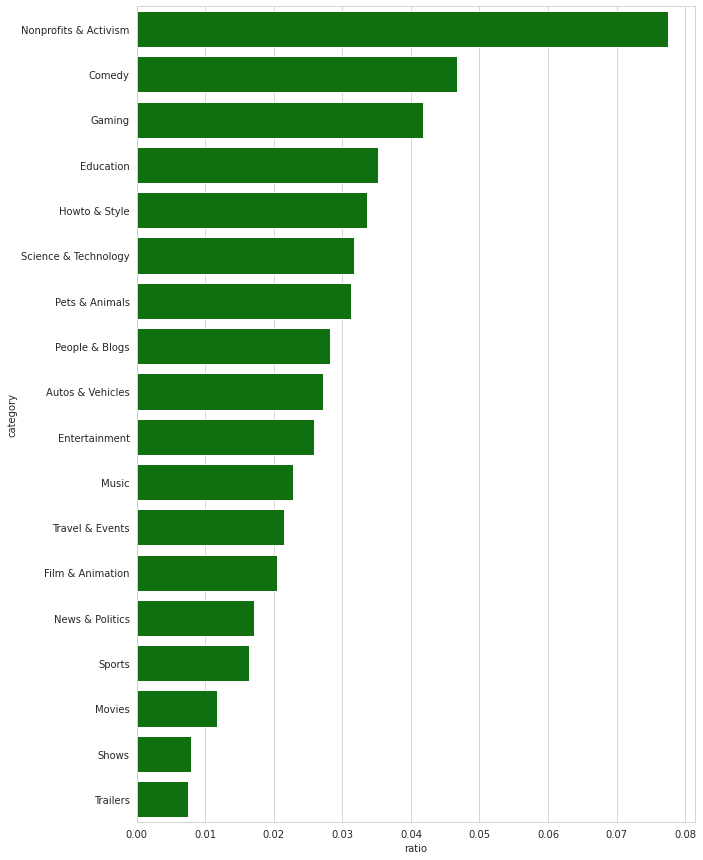

In [ ]:
view_like_ratio = my_df.groupby('category')['likes'].agg('sum') / my_df.groupby('category')['views'].agg('sum')
view_like_ratio = view_like_ratio.sort_values(ascending=False).reset_index()
view_like_ratio.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=view_like_ratio,
            label="Views-Likes Ratio", color="g")

**Observation:**
1. Pets & Animals videos have highest likes-dislikes ratio. Not suprisingly, people find difficult to hate pets and animals.
2. Nonprofit & Activism's videos have lowest likes-dislike ratio and views-comments ratio. People relatively hate these video and comment a lot.
3. Obviosly, people still prefer implicit feedback than explicit. The ratio of views to comments is so large that only a comment written for hundreds of views.\

Remarks: Also, I would like to hear any interesting facts that you found. Please comment below.

##**Analysis: Sentiment analysis on Video's tags**

###**Import libraries**

In [ ]:
from wordcloud import WordCloud
import nltk
#nltk.download()
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
MAX_N = 1000

#remove all the stopwords from the text
en_stopwords = list(stopwords.words('english'))
de_stopwords = list(stopwords.words('german'))   
fr_stopwords = list(stopwords.words('french'))   
en_stopwords.extend(de_stopwords)
en_stopwords.extend(fr_stopwords)

AttributeError: ignored

In [ ]:
polarities = list()

for cate in category_list:
    tags_word = my_df[my_df['category']==cate]['tags'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
    tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
    word_tokens = word_tokenize(tags_word)
    filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]      
    
# Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    hnhk = pd.DataFrame(word_dist.most_common(MAX_N),
                    columns=['Word', 'Frequency'])

    compound = .0
    for word in hnhk['Word'].head(MAX_N):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']

    polarities.append(compound)

category_list = pd.DataFrame(category_list)
polarities = pd.DataFrame(polarities)
tags_sentiment = pd.concat([category_list,polarities],axis=1)
tags_sentiment.columns = ['category','polarity']
tags_sentiment=tags_sentiment.sort_values('polarity').reset_index()

plt.figure(figsize=(16,10))
sns.set(style="white",context="talk")
ax = sns.barplot(x=tags_sentiment['polarity'],y=tags_sentiment['category'], data=tags_sentiment,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("polarity")
plt.title("Polarity of Categories in Youtube videos")